In [10]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.naive_bayes as nb
import warnings
warnings.filterwarnings("ignore")

### 1) IN THIS SECTION, I DO THE DATA LOADING AND THE NECESSARY PREPROCESSING TO BE ABLE TO RUN THE TRAIN, PREDICT AND EVALUATE FUNCTIONS

In [2]:
def cleanCorrelatedFeatures(corr, data, tol):
    """Removes the vector features that are correlated more than the value specified in tol argument
    
    Arguments:
    corr --Correlations between features
    data --The data containing the features
    tol --Percentage indicating the maximum threshold of correlation to be tolerated i.e. 95%
    """
    
    columns = np.full((corr.shape[0],), True, dtype=bool) #Creates array with size =the feature space and fills it with True
    for i in range(corr.shape[0]):         #Next, we compare the correlation between features and remove one of two                                   
        for j in range(i+1, corr.shape[0]): #features that have a correlation higher than 0.9
            if corr.iloc[i,j] >= tol:
                if columns[j]:
                    columns[j] = False
    selected_columns = data.columns[columns] #Creates Index with the columns that were True after cleaning
    data = data[selected_columns] # Data with only the selected columns
    return data

In [3]:
train_feat = pd.read_csv('train_features.csv')
tag_df=pd.DataFrame(train_feat['tags'])
metadata_df_train=pd.DataFrame(train_feat[['loudness','tempo','duration', 'time_signature','key','mode']])
train_feat=train_feat.drop(columns=['trackID','title','tags','loudness','tempo','duration', 'time_signature','key','mode']) #


#Extracts features from tags
vect= CountVectorizer(lowercase=True, analyzer='word')
tag_feat=vect.fit_transform(tag_df['tags']).toarray()

#Converts vectorized training tag features to dataFrame 
tag_df_train=pd.DataFrame(tag_feat, columns=vect.get_feature_names())


#Reads info about training labels
train_lab=pd.read_csv('train_labels.csv')
train_lab=train_lab.drop(columns=['trackID'])
train_lab=train_lab['genre'].astype(str)



In [4]:
#FEATURE SELECTION FOR METADATA
mutual_info= mutual_info_classif(metadata_df_train,train_lab, random_state=1)
mutual_info_np=pd.DataFrame(mutual_info).to_numpy()
mutual_info_df=pd.DataFrame(mutual_info_np, index=metadata_df_train.columns.to_numpy())
mutual_info_df.rename(columns={0:'Mutual_Information'})

,Mutual_Information
loudness,0.205847
tempo,0.076935
duration,0.084664
time_signature,0.015097
key,0.016781
mode,0.007436


In [5]:
#DROP FEATURES WITH LOW MI
metadata_df_train=metadata_df_train.drop(columns=['time_signature','key','mode'])

(148, 148)


<AxesSubplot:>

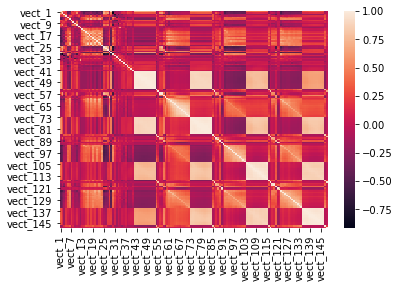

In [6]:
#Obtain vector correlations and display them in a heatmap
corr=train_feat.corr()
print(corr.shape)
sns.heatmap(corr)

In [9]:
#ELIMINATES VECTORS WITH CORRELATION GREATER THAN 95%
train_feat=cleanCorrelatedFeatures(corr,train_feat, 0.95)
train_feat

,vect_1,vect_2,vect_3,vect_4,vect_5,vect_6,vect_7,vect_8,vect_9,vect_10,...,vect_127,vect_128,vect_129,vect_130,vect_131,vect_132,vect_133,vect_134,vect_135,vect_147
0,52.050795,55.591771,20.057026,-0.274684,-21.032160,-26.402589,9.069553,-5.114241,12.278786,7.204824,...,0.098362,0.100361,0.102743,0.094543,0.090050,0.101821,0.096166,0.101980,0.000965,0.104525
1,38.488583,-38.186087,-5.917110,-12.937670,24.165450,-9.554361,-6.211903,-1.587171,-5.841613,-6.813095,...,0.173388,0.181092,0.173045,0.143824,0.131520,0.129642,0.121102,0.131946,0.000132,0.124080
2,45.424130,36.587988,24.220092,-5.630071,-2.040036,-1.773653,-4.970089,-0.929461,1.146745,2.746805,...,0.244096,0.213397,0.129625,0.130447,0.118786,0.113963,0.105601,0.102615,0.000912,0.311885
3,42.546616,47.126411,23.625371,-7.261937,-32.777558,-21.147418,0.885373,5.195450,1.758235,2.748629,...,0.120056,0.115440,0.112799,0.094716,0.089971,0.100931,0.098607,0.095706,0.000146,0.115680
4,36.161980,-6.806859,14.974707,-4.010917,-6.013255,-10.778433,1.910432,2.785765,4.111437,5.423926,...,0.076727,0.081885,0.099242,0.100832,0.100894,0.087798,0.085282,0.109373,0.000074,0.186119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,40.258501,-52.111872,19.853431,21.129912,-25.566925,7.085300,13.279649,-2.114198,1.550226,-5.945500,...,0.159373,0.164589,0.134495,0.143745,0.130959,0.134649,0.127241,0.119603,0.001377,0.184104
7674,51.767393,68.259900,0.104259,-7.568613,-34.780593,-18.211187,-9.101715,-1.826457,7.313411,9.014474,...,0.150234,0.094102,0.097285,0.093063,0.080631,0.070100,0.087020,0.080510,0.000492,0.075420
7675,40.285352,12.846995,18.955819,-4.602336,-19.859749,-8.962781,-8.666059,-4.098057,-1.816392,-2.658524,...,0.142232,0.138019,0.107894,0.119948,0.117380,0.094246,0.106676,0.124233,0.000180,0.169215
7676,52.670728,55.895759,28.188279,-1.247562,-15.309953,-19.836597,-6.213078,-6.544634,4.846657,3.946768,...,0.102216,0.089777,0.089398,0.092234,0.095829,0.101353,0.079907,0.085800,0.000838,0.181243


Loudness, tempo and duration have the greatest Mutual Information. Therefore, I will include them and drop the others

In [11]:
#Performs scaling and binnig over the numerical attributes
from sklearn.preprocessing import KBinsDiscretizer

#MinMax Scaling
scaler = MinMaxScaler()

#Trying to do the same but with dataframe
scaler.fit(train_feat)
X_train=scaler.transform(train_feat)

#Binning
binner=KBinsDiscretizer(n_bins=8, encode='ordinal',strategy='quantile')
binner.fit(train_feat)
X_train=binner.transform(train_feat)

#Transform back to Dataframe
train_feat=pd.DataFrame(X_train, columns=train_feat.columns)

In [12]:
#Performs scaling and binnig over METADATAfeatures

#MinMax Scaling
scaler2 = MinMaxScaler()

#Trying to do the same but with dataframe
scaler2.fit(metadata_df_train)
X_meta_train=scaler2.transform(metadata_df_train)

#Binning
binner2=KBinsDiscretizer(n_bins=8, encode='ordinal',strategy='quantile')
binner2.fit(metadata_df_train)
X_meta_train=binner2.transform(metadata_df_train)

#Transform back to Dataframe format
metadata_df_train=pd.DataFrame(X_meta_train, columns=metadata_df_train.columns)

In [15]:
#VALIDATION FEATURES
valid_feat = pd.read_csv('valid_features.csv')
tag_df_valid=pd.DataFrame(valid_feat['tags']) # Separating the data from the tags into a different data

#Creates dataframe with only metadata and drops not selected features
metadata_df_valid=pd.DataFrame(valid_feat[['loudness','tempo','duration', 'time_signature','key','mode']])
metadata_df_valid=metadata_df_valid.drop(columns=['time_signature','key','mode'])

#valid_feat=valid_feat.drop(columns=['trackID','title','tags', 'time_signature','key','mode']) #Use combined with metadata
valid_feat=valid_feat.drop(columns=['trackID','title','tags','loudness','tempo','duration', 'time_signature','key','mode'])


#ELiminating vector features whose corr is >=95%
valid_feat=cleanCorrelatedFeatures(corr,valid_feat, 0.95)

#Performs MinMax scaling and then binnig over the vector features
X_valid=scaler.transform(valid_feat)
X_valid=binner.transform(valid_feat)

#Transforms validation NUMERICAL features back to DataFrame format 
valid_feat=pd.DataFrame(X_valid, columns=valid_feat.columns)

#Performs MinMax scaling and then binnig over the METADATA
X_meta_valid=scaler2.transform(metadata_df_valid)
X_meta_valid=binner2.transform(metadata_df_valid)

#Transforms validation METADATA back to DataFrame forma
metadata_df_valid=pd.DataFrame(X_meta_valid, columns=metadata_df_valid.columns)

#Finally, read validation labels
valid_lab=pd.read_csv('valid_labels.csv')
valid_lab=valid_lab.drop(columns=['trackID'])
valid_lab=valid_lab['genre'].astype(str)



In [16]:
def adjustUnknownFeatures(original_df, eval_df):
    """Adjusts the vecto features used in the validtion set to match those in the training set
    
    Arguments:
    original_df -- Dataframe containing features used in training set
    eval_df -- Datafame containing features in the validation set
    """
    columns_original=original_df.columns
    columns_eval=eval_df.columns
    #Creates dataframe X=#rows in evaluation dataframe and Y= Number of columns (features) in training set 
    numpyZero=np.zeros((len(eval_df.index),len(columns_original)))
    new_df=pd.DataFrame(numpyZero, columns=columns_original) 
    bool_columns =np.full((len(columns_original),), False, dtype=bool)
    for i in range(len(columns_original)):
        if columns_original[i] in columns_eval:
            new_df[columns_original[i]]=eval_df[columns_original[i]]
    
    return new_df

In [17]:
#Count vectorizes the VALIDATION tag features and transforme them into an array
tag_feat_valid=vect.fit_transform(tag_df_valid['tags']).toarray()


#Converts vectorized valid tag features to dataFrame
textDf_valid=pd.DataFrame(tag_feat_valid, columns=vect.get_feature_names())
textDf_valid

adjusted_tag_df_valid=adjustUnknownFeatures(tag_df_train,textDf_valid)

print("train shape: ",tag_df_train.shape)
print("train sum: ",tag_df_train.values.sum())
print("valid shape: ",textDf_valid.shape)
print("valid sum: ",textDf_valid.values.sum())
print("adjusted shape",adjusted_tag_df_valid.shape)
print("adjusted sum: ",adjusted_tag_df_valid.values.sum())


train shape:  (7678, 4827)
train sum:  601013
valid shape:  (450, 3368)
valid sum:  32296
adjusted shape (450, 4827)
adjusted sum:  32282.0


In [18]:
#BASELINE MODEL

zeroR_clf =DummyClassifier(strategy="most_frequent")

zeroR_clf.fit(train_feat, train_lab)

acc_baseline= zeroR_clf.score(valid_feat, valid_lab)

print("zeroR baseline score %f " %acc_baseline)
print('corss-val acc:', np.mean(cross_val_score(zeroR_clf, train_feat, train_lab, cv=5)))

zeroR baseline score 0.122222 
corss-val acc: 0.21216468173181324


In [19]:
#Now we will mix both fetures and run the models:

#Concatenates dataframe of TRAINING tag features and vectors

#First we transform validation numerical features back to DataFrame format so it can be concatenated
#train_df_feat=pd.DataFrame(X_train, columns=train_feat.columns) 

train_concat_meta_tag=pd.concat([metadata_df_train,train_feat], axis=1 )
train_concat=pd.concat([tag_df_train,train_concat_meta_tag], axis=1 )
train_concat

print(train_concat.values.min())


#Now we proceed to concatenation
valid_concat_meta_tag=pd.concat([metadata_df_valid,valid_feat], axis=1 )
valid_concat=pd.concat([adjusted_tag_df_valid,valid_concat_meta_tag],axis=1)


0.0


## 2) CREATION OF THE MODELS

In [20]:
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.model_selection import train_test_split

#Used for  metadata features
mnb3 = MultinomialNB()
cnb3 = CategoricalNB()
lgr3= LogisticRegression(random_state=1)

#Used for  vector features
mnb = MultinomialNB()
cnb = CategoricalNB()
lgr= LogisticRegression(random_state=1)
                         
#Used for tag features
mnb1 = MultinomialNB()
cnb1 = CategoricalNB()
lgr1= LogisticRegression(random_state=1)
    
#Used for all features
mnb2 = MultinomialNB()
cnb2 = CategoricalNB()
lgr2= LogisticRegression(random_state=1)                 

In [22]:
#TRAIN FUNCTION

def train(metadata_df_train,train_feat, tag_df_train, train_concat, train_lab):
    """Trains 3 ML models with different types of features
    
    Arguments:
    metadata_df_train -- dataframe with metadata features
    train_feat --dataframe with vector features
    tag_df_train -- dataframe with tag features
    train_concat -- concatenated dataframe with all the previous features
    train_lab --training labels
    """
    
    #Trains with metadata features
    mnb3.fit(metadata_df_train, train_lab)
    cnb3.fit(metadata_df_train, train_lab)
    lgr3.fit(metadata_df_train, train_lab)    
    
    #Trains with vector features
    mnb.fit(train_feat, train_lab)
    cnb.fit(train_feat, train_lab)
    lgr.fit(train_feat, train_lab)

    #Trains with tag features
    mnb1.fit(tag_df_train, train_lab)
    cnb1.fit(tag_df_train, train_lab)
    lgr1.fit(tag_df_train, train_lab)
    
    #Trains with all features
    mnb2.fit(train_concat, train_lab)
    cnb2.fit(train_concat, train_lab)
    lgr2.fit(train_concat, train_lab)
    

In [23]:
def predict(metadata_df_valid, valid_feat, adjusted_tag_df_valid, valid_concat):
    """Makes predictions on the trained models using the validation features
    
    Arguments:
    metadata_df_valid -- dataframe with metadata features
    valid_feat --dataframe with vector features
    adjusted_tag_df_valid -- dataframe with tag features
    valid_concat -- concatenated dataframe with all the previous features
    """
    
    #predict with metadata features
    mnb3.predict(metadata_df_valid)
    cnb3.predict(metadata_df_valid)
    lgr3.predict(metadata_df_valid)    
    
    #predict with vector features
    mnb.predict(valid_feat)
    cnb.predict(valid_feat)
    lgr.predict(valid_feat)

    #predict with tag features
    mnb1.predict(adjusted_tag_df_valid)
    cnb1.predict(adjusted_tag_df_valid)
    lgr1.predict(adjusted_tag_df_valid)
    
    #predict with all features
    mnb2.predict(valid_concat)
    cnb2.predict(valid_concat)
    lgr2.predict(valid_concat)
    

In [24]:
def evaluate(metadata_df_valid, valid_feat, adjusted_tag_df_valid, valid_concat, valid_lab):
    """Evaluates the models using the validation labels
    
    Arguments:
    metadata_df_valid -- dataframe with metadata features
    valid_feat --dataframe with vector features
    adjusted_tag_df_valid -- dataframe with tag features
    valid_concat -- concatenated dataframe with all the previous features
    valid_lab -- labels of the validation set
    """
    
    models =['Multinomial NB', 'Categorical NB', 'Logistic Reg']
    set_features=['Metadata','Vectors','Tags','All']
    accur= pd.DataFrame(index=models, columns=set_features)
    
    acc_aux=[]
    # Evaluates with metadata features
    acc_aux.append(mnb3.score(metadata_df_valid,valid_lab))
    acc_aux.append(cnb3.score(metadata_df_valid,valid_lab))
    acc_aux.append(lgr3.score(metadata_df_valid,valid_lab))   
    accur['Metadata']=acc_aux
    
    
    # Evaluates with vector features
    acc_aux=[]
    acc_aux.append(mnb.score(valid_feat,valid_lab))
    acc_aux.append(cnb.score(valid_feat,valid_lab))
    acc_aux.append(lgr.score(valid_feat,valid_lab))
    accur['Vectors']=acc_aux
    
    # Evaluates with tag features
    acc_aux=[]
    acc_aux.append(mnb1.score(adjusted_tag_df_valid, valid_lab))
    acc_aux.append(cnb1.score(adjusted_tag_df_valid, valid_lab))
    acc_aux.append(lgr1.score(adjusted_tag_df_valid, valid_lab))
    accur['Tags']=acc_aux
    
    # Evaluates with all features
    acc_aux=[]
    acc_aux.append(mnb2.score(valid_concat, valid_lab))
    acc_aux.append(cnb2.score(valid_concat, valid_lab))
    acc_aux.append(lgr2.score(valid_concat, valid_lab))
    accur['All']=acc_aux
    
    return accur

### PLEASE MAKE SURE TO RUN EVERYTHING ABOVE BEFORE RUNNING THIS DRIVER FUNCTION

In [25]:
#################################################DRIVER FUNCTION##############################################################
train(metadata_df_train,train_feat, tag_df_train, train_concat, train_lab)

accuracies = evaluate(metadata_df_valid, valid_feat, adjusted_tag_df_valid, valid_concat, valid_lab)

accuracies

,Metadata,Vectors,Tags,All
Multinomial NB,0.235556,0.406667,0.577778,0.671111
Categorical NB,0.295556,0.453333,0.542222,0.691111
Logistic Reg,0.300000,0.475556,0.537778,0.633333


In [29]:
#LEARNING CURVE
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(mnb2, train_concat, train_lab, train_sizes=[50, 80, 110], cv=5)

In [27]:
#PRINTS ALL THE CROSS-VALIDATION ACCURACIES


print('corss-val Multinom NB acc:', np.mean(cross_val_score(mnb3, metadata_df_train, train_lab, cv=5)))
print('corss-val Categori NB acc:', np.mean(cross_val_score(cnb3, metadata_df_train, train_lab, cv=5)))
print('corss-val Log Regress acc:', np.mean(cross_val_score(lgr3, metadata_df_train, train_lab, cv=5)))

print('corss-val Multinom NB acc:', np.mean(cross_val_score(mnb, train_feat, train_lab, cv=5)))
print('corss-val Categori NB acc:', np.mean(cross_val_score(cnb, train_feat, train_lab, cv=5)))
print('corss-val Log Regress acc:', np.mean(cross_val_score(lgr, train_feat, train_lab, cv=5)))


cnb_aux1=CategoricalNB()
cross_acc=[]
for i in range(1,6):
    X_tr, X_tst, y_tr, y_tst = train_test_split(tag_df_train,train_lab, random_state=i,test_size=0.2, stratify=train_lab)
    cnb_aux1.fit(X_tr,y_tr)
    score=cnb1.score(X_tst,y_tst)
    cross_acc.append(score)

print('corss-val Multinom NB acc:', np.mean(cross_val_score(mnb1, tag_df_train, train_lab, cv=5)))
print('corss-val Categori NB acc:', np.mean(cross_acc))
print('corss-val Log Regress acc:', np.mean(cross_val_score(lgr1, tag_df_train, train_lab, cv=5)))


cnb_aux2=CategoricalNB()
cross_acc=[]
for i in range(1,6):
    X_tr, X_tst, y_tr, y_tst = train_test_split(train_concat,train_lab, random_state=i,test_size=0.2, stratify=train_lab)
    cnb_aux2.fit(X_tr,y_tr)
    score=cnb2.score(X_tst,y_tst)
    cross_acc.append(score)

print('cross-val Multinom NB acc:', np.mean(cross_val_score(mnb2, train_concat, train_lab, cv=5)))
print('cross-val Categori NB acc:', np.mean(cross_acc))
print('cross-val Log Regress acc:', np.mean(cross_val_score(lgr2, train_concat, train_lab, cv=5)))


corss-val Multinom NB acc: 0.30893186753528773
corss-val Categori NB acc: 0.3664984561617807
corss-val Log Regress acc: 0.37144942657437563
corss-val Multinom NB acc: 0.42758779519543977
corss-val Categori NB acc: 0.44321457654723134
corss-val Log Regress acc: 0.5590009161237786
corss-val Multinom NB acc: 0.49492085708469064
corss-val Categori NB acc: 0.5744791666666667
corss-val Log Regress acc: 0.47303873167752447
corss-val Multinom NB acc: 0.5664243179967426
corss-val Categori NB acc: 0.630078125
corss-val Log Regress acc: 0.6265958367263844


## 3) THIS PART MAKES PREDICTIONS OVER THE TEST SET TO SUBMIT TO KAGGLE. IT IS NECESSARY TO HAVE RUN EVERYTHING ABOVE FOR THIS TO WORK

In [24]:
# Here is space to run the model over the test features to submit to Kaggle

#Reading test features
test_feat = pd.read_csv('test_features.csv')
output_df=pd.DataFrame(test_feat['trackID']) # This will be used to generate the output to csv
tag_df_test=pd.DataFrame(test_feat['tags']) # Separating the data from the tags into a different data

metadata_df_test=pd.DataFrame(test_feat[['loudness','tempo','duration', 'time_signature','key','mode']])
metadata_df_test=metadata_df_test.drop(columns=['time_signature','key','mode'])

test_feat=test_feat.drop(columns=['trackID','title','tags','loudness','tempo','duration', 'time_signature','key','mode'])


In [25]:
#PRE-PROCESSING FOR NUMERICAL ATTRIBUTES (VECTORS):

#ELiminating vector features whose corr (in the training set) is >=95% 
test_feat=cleanCorrelatedFeatures(corr,test_feat)

#Performs MinMax scaling and then binnig over the numerical attributes
X_test=scaler.transform(test_feat)
X_test=binner.transform(test_feat)
#Transforms validation NUMERICAL features back to DataFrame format 
test_feat=pd.DataFrame(X_test, columns=test_feat.columns)


#Performs MinMax scaling and then binnig over the METADATA
X_meta_test=scaler2.transform(metadata_df_test)
X_meta_test=binner2.transform(metadata_df_test)
#Transforms validation METADATA back to DataFrame forma
metadata_df_test=pd.DataFrame(X_meta_test, columns=metadata_df_test.columns)


In [26]:
#PRE-PROCESSING FOR TEXT ATTRIBUTES (TAGS):

#Count vectorizes the tag features and transforme them into an array
tag_feat_test=vect.fit_transform(tag_df_test['tags']).toarray()

#Converts vectorized valid tag features to dataFrame
text_test_df=pd.DataFrame(tag_feat_test, columns=vect.get_feature_names())

#Adjusts test tags matrix so it is of the same shape as the train tags matrix
adjusted_tag_df_test=adjustUnknownFeatures(tag_df_train,text_test_df)
adjusted_tag_df_test

,10,100,12,13,15,16,20,24,2x,30,...,zum,zur,zurück,zwei,är,ça,él,était,être,über
0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#JOINING BOTH SETS OF FEATURES (TAGS+VECTORS):

#Concatenates dataframe of VALIDATION tag features and vectors

test_concat_meta_tag=pd.concat([metadata_df_test,test_feat], axis=1 )
test_concat=pd.concat([adjusted_tag_df_test,test_concat_meta_tag], axis=1 )
test_concat


,10,100,12,13,15,16,20,24,2x,30,...,vect_127,vect_128,vect_129,vect_130,vect_131,vect_132,vect_133,vect_134,vect_135,vect_147
0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,2.0,3.0,1.0,1.0,3.0,3.0,1.0,3.0,3.0,5.0
1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,7.0,5.0,3.0,6.0,4.0,4.0,3.0,6.0,2.0,7.0
3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,5.0,6.0,5.0,4.0,6.0,4.0,2.0,1.0,1.0,6.0
4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,7.0,5.0,5.0,7.0,5.0,5.0,3.0,3.0,7.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,5.0,5.0,5.0,6.0,5.0,6.0,6.0,6.0,5.0,6.0
424,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,3.0,5.0,4.0,5.0,6.0,7.0,5.0,3.0,2.0,0.0
425,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,4.0,4.0,6.0,5.0,6.0,4.0,3.0,4.0,0.0,7.0
426,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,7.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,3.0,4.0


In [28]:
#PREDICTION USING CATEGORICAL NAIVE BAYES
predictions=cnb2.predict(test_concat)
predictions

output_df['genre']=pd.DataFrame(predictions)
output_df

output_df.to_csv(r'C:\Users\Diego\ML\results_feat_select_CAT_all.csv',index=False)